# Image Denoising

## Import relevant libraries

In [ ]:
#Import Numpy for matrix operations
import numpy as np

#Import the normalize function from preprocessing package from sklearn
from sklearn.preprocessing import normalize

#Import the Orthogonal Matching Pursuit Algorithm from Scikit-Learn, for 
#the implementation of the K-SVD and Approximate K-SVD algorithm
from sklearn.linear_model import orthogonal_mp

#Import the Sparse SVD function from scipy, used in the original SVD algorithm
from scipy.sparse.linalg import svds

#Import the norm function from the linear algebra package of numpy, used in 
#the implementation of K-SVD
from numpy.linalg import norm, inv

#Import the walk function from the os package to perform file operations
from os import walk

from PIL import Image
import matplotlib.pyplot as plt


## Approximate K-SVD

In [ ]:
#Implementation of the Approximate K-SVD algorithm (Rubinstein et. al (2008))
def Approx_K_SVD(signal_set, dictionary_size, sparsity, n_iterations=100, D=None):

    #get the number of features (Signal size)
    n_features = signal_set.shape[0]

    #initlialise the dictionary 
    if D is None:
        D = np.random.randn(n_features, dictionary_size)

    #normalize the columns of D
    D = normalize(D, norm='l2', axis = 0)
    norm_score = 1000
    
    for iteration in range(n_iterations):
        print("Iteration:", iteration)
        #-----------------------------------------------------------------------
        #                         Spare Coding Step
        #-----------------------------------------------------------------------
        #Here, we run the OMP algorithm on the dictionary and the signal set to
        #obtain the sparse code for the current iteration
 
        sparse_code = orthogonal_mp(D, signal_set, sparsity)
        #loop through every column of D to update
        for i in range(dictionary_size):
            #make the current column zero. 
            #This is a simplification for the code that follows
            D[:, i] = np.zeros((n_features))
            #find the signals that used the column i of the dictionary D
            indices = np.nonzero(sparse_code[i, :])
            if indices[0].size == 0:
                continue

            #----------------------------------------------------------------------
            #                     Dictionary update step
            #----------------------------------------------------------------------
            # Instead of using an SVD decomposition as above, we use an approximate
            # method as proposed in the paper by Rubinstein et. al (2008)

            g = sparse_code[i, indices[0]].T
            temp = signal_set[:, indices[0]] - D.dot(sparse_code[:, indices[0]])
            d = temp.dot(g)
            d = normalize(d.reshape(-1,1), axis=0)
            g = temp.T.dot(d)
            D[:, i] = d.ravel()
            sparse_code[i, indices[0]] = g.T

        print(norm(signal_set-np.matmul(D, sparse_code)))
        norm_score = norm(signal_set-np.matmul(D, sparse_code))/norm(signal_set)
         
    return D, sparse_code

## Utility Functions

In [ ]:
def get_patch(i, j, n, image):
    K = int(np.sqrt(n))
    R = np.zeros((K, K, 3))
    img_data = np.asarray(image)
    R = img_data[i:i+K, j:j+K]
    """for k in range(K):
        for l in range(K):
            R[k,l, :] = img_data[i+k, j+l, :]
       """ 
    return R

In [ ]:
def get_patch_single(i, j, n, image):
    K = int(np.sqrt(n))
    R = np.zeros((K, K, 1))
    img_data = np.asarray(image)
    R = img_data[i:i+K, j:j+K]
    """for k in range(K):
        for l in range(K):
            R[k,l, :] = img_data[i+k, j+l, :]
       """ 
    return R

In [ ]:
def extract_patches(img_data, patch_size):
    K = int(np.sqrt(patch_size))
    n_patches = int(img_data.shape[0] * img_data.shape[1]/patch_size)
    X = np.zeros((patch_size*3, n_patches))

    for i in range(int(img_data.shape[0]/K)):
        for j in range(int(img_data.shape[1]/K)):
            X[:, i*int(img_data.shape[0]/K)+j] = get_patch(i*K, j*K, patch_size, img_data).flatten()
    return  X

In [ ]:
def extract_patches_single(img_data, patch_size):
    K = int(np.sqrt(patch_size))
    n_patches = int(img_data.shape[0] * img_data.shape[1]/patch_size)
    X = np.zeros((patch_size, n_patches))

    for i in range(int(img_data.shape[0]/K)):
        for j in range(int(img_data.shape[1]/K)):
            X[:, i*int(img_data.shape[0]/K)+j] = get_patch_single(i*K, j*K, patch_size, img_data).flatten()
    return  X

In [ ]:
def extract_patches_stride(img_data, patch_size, stride):
    K = int(np.sqrt(patch_size))
    n_patches = int(img_data.shape[0]/stride * img_data.shape[1]/stride)
    X = np.zeros((patch_size*3, n_patches))
    print(X.shape)
    for i in range(0, img_data.shape[0], stride):
        for j in range(0, img_data.shape[1], stride):
            t = get_patch(i*stride, j*stride, patch_size, img_data).flatten()
            if t.size == patch_size*3:
                X[:, i*int(img_data.shape[0]/stride)+j] = t
    return  X

In [ ]:
def recreate_image(patch_array, img_data_shape, patch_size):
    K = int(np.sqrt(patch_size))
    new_img = np.zeros((img_data_shape[0], img_data_shape[1], 3))
    for i in range(int(img_data_shape[0]/K)):
        for j in range(int(img_data_shape[1]/K)):
            new_img[i*K:(i+1)*K, j*K:K*(j+1), :] = patch_array[:, i*int(img_data_shape[0]/K) + j].reshape(K, K, 3)
    return new_img

In [ ]:
def recreate_image_single(patch_array, img_data_shape, patch_size):
    K = int(np.sqrt(patch_size))
    new_img = np.zeros((img_data_shape[0], img_data_shape[1], 1))
    for i in range(int(img_data_shape[0]/K)):
        for j in range(int(img_data_shape[1]/K)):
            new_img[i*K:(i+1)*K, j*K:K*(j+1), :] = patch_array[:, i*int(img_data_shape[0]/K) + j].reshape(K, K, 1)
    return new_img

In [ ]:
def post_process(img_data):
    img_data = np.minimum(img_data, np.full(img_data.shape, 255.0))
    img_data = np.maximum(img_data, np.full(img_data.shape, 0.0))
    return img_data

In [ ]:
def noise_image(img_data, var=0.1):
    noisy_data = (img_data/255 +  var*np.random.randn(img_data.shape[0], img_data.shape[1], 3))*255 #* img_data
    noisy_data = post_process(noisy_data)
    
    return noisy_data

In [ ]:
variance = 0.3
patch_size = 16

In [ ]:
image = Image.open('faces/face2.png')
image = image.resize((512, 512))
img_data = np.asarray(image)
print(img_data.shape)
#img_data = np.mean(img_data, axis=2)
noisy_data = noise_image(img_data, variance)
#noisy_data [noisy_data>255] -= 255
#noisy_data [noisy_data<0] += 255

X = extract_patches(noisy_data, patch_size)
print(X.shape)

(512, 512, 3)
(48, 16384)


In [ ]:
image = Image.open('faces/face1.jpg')
image = image.resize((512, 512))
img_data = np.asarray(image)
print(img_data.shape)
#img_data = np.mean(img_data, axis=2)
noisy_data = noise_image(img_data, variance)
#noisy_data [noisy_data>255] -= 255
#noisy_data [noisy_data<0] += 255

temp = extract_patches(noisy_data, patch_size)
print(temp.shape)

(512, 512, 3)
(48, 16384)


In [ ]:
X = np.concatenate((X, temp), axis=1)
print(X.shape)

(48, 32768)


In [ ]:
image = Image.open('image.jpg')
image = image.resize((1024, 1024))
img_data = np.asarray(image)
print(img_data.shape)
#img_data = np.mean(img_data, axis=2)


(1024, 1024, 3)


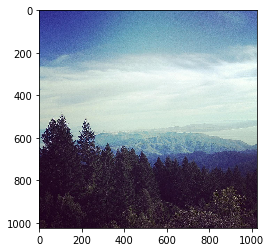

In [ ]:
plt.imshow(img_data)

In [ ]:
noisy_data = noise_image(img_data, var=variance)
#noisy_data [noisy_data>255] -= 255
#noisy_data [noisy_data<0] += 255


image3 = Image.fromarray(noisy_data.astype('uint8'))
image3.show()

In [ ]:
newX = extract_patches(noisy_data, patch_size)

In [ ]:
print(newX.shape)

(48, 65536)


In [ ]:
print(noisy_data.shape)
non_zero = 2

(1024, 1024, 3)


In [ ]:
D, sparse_code = Approx_K_SVD(newX, 100, non_zero, 100)

Iteration: 0
117928.69276019117
Iteration: 1
99744.20895047615
Iteration: 2
97589.04537870323
Iteration: 3
96666.59197887678
Iteration: 4
96054.08508437817
Iteration: 5
95646.30308255789
Iteration: 6
95370.96600899535
Iteration: 7
95176.1840140116
Iteration: 8
95030.07347723666
Iteration: 9
94910.45834627452
Iteration: 10
94809.24047459394
Iteration: 11
94719.19549714847
Iteration: 12
94632.20737689313
Iteration: 13
94541.06674689193
Iteration: 14
94457.3558833516
Iteration: 15
94371.47958909092
Iteration: 16
94291.87616686145
Iteration: 17
94225.05180100523
Iteration: 18
94161.05339134272
Iteration: 19
94107.93697868471
Iteration: 20
94057.11541119966
Iteration: 21
94011.26585091223
Iteration: 22
93969.12633174911
Iteration: 23
93929.13672456739
Iteration: 24
93890.34695818767
Iteration: 25
93855.75641983667
Iteration: 26
93820.1562008806
Iteration: 27
93786.83805759042
Iteration: 28
93757.78648784112
Iteration: 29
93732.9969504708
Iteration: 30
93710.90480397786
Iteration: 31
93689.8

In [ ]:
newX = extract_patches(noisy_data, patch_size)

In [ ]:
print(newX.shape)

(48, 65536)


In [ ]:
new_sparse = orthogonal_mp(D, newX, n_nonzero_coefs = non_zero)

In [ ]:
new_img = recreate_image(D.dot(sparse_code), (image3.size[0], image3.size[1]), patch_size)
new_img = post_process(new_img)

In [ ]:
print(new_img.shape)

(1024, 1024, 3)


In [ ]:
Image.fromarray(new_img.astype(np.uint8)).show()

In [ ]:
Image.fromarray(noisy_data.astype('uint8')).save('noisy.png')
Image.fromarray(new_img.astype('uint8')).save('denoised.png')